In [52]:
#Imports
import sys

from datetime import date
from datetime import datetime

import IPython
from ipywidgets import IntProgress

import numpy as np
import PIL
import random

import matplotlib.pyplot as plt

#Import Local PY Files
import Models

In [4]:
#Some Global Vars
latent_dim = 256
imgSize = 64


In [5]:
#Load Decoder Model Only as we are going to be directly injecting our own latent space values

model = Models.CVAE(latent_dim,imgSize)

checkpoint_path = "../Training/checkpoints/cp-decode-base2.ckpt"
model.decoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 layer_normalization (LayerN  (None, 256)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8192)              2105344   
                                                                 
 layer_normalization_1 (Laye  (None, 8192)             16384     
 rNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       1

In [6]:
def creatSingleRandom2DVecInSpace(latent_dim,randomRange):
    emtpyVec = np.ndarray(shape=(latent_dim))
    for i in range(latent_dim):
        emtpyVec[i] = random.gauss(mu=0.0, sigma=randomRange)
    
    return emtpyVec

In [7]:
def postProcessesImage(img):
    img = img.resize((imgSize*4,imgSize*4),resample=PIL.Image.NEAREST)
  
    for passes in range(10):
        img = img.filter(PIL.ImageFilter.MedianFilter(size=3))  
    
    img = img.resize((imgSize,imgSize),resample=PIL.Image.LANCZOS)

    img = img.point( lambda p: 255 if p > 150 else 0 )
    
    return img

In [8]:
def createRandomSet(plotSize,latent_dim,randomRange):
    plotSizeSquare = plotSize * plotSize
    #Create space for our random latent space dims
    latentSpaceGlyhs = np.ndarray(shape=(plotSizeSquare, latent_dim), dtype=np.float32)

    #Fill out our vector
    for i in range(plotSizeSquare):
        latentSpaceGlyhs[i] = creatSingleRandom2DVecInSpace(latent_dim,randomRange)
    
    predictions = model.sample(latentSpaceGlyhs)
    fig = plt.figure(figsize=(plotSize, plotSize))
    nPredictions = predictions.numpy() * 255
    nPredictions = nPredictions.astype(np.uint8)
    for i in range(nPredictions.shape[0]):
        imgData = nPredictions[i, :, :, 0]
        (imgData-np.min(imgData))/(np.max(imgData)-np.min(imgData)) 
        img = PIL.Image.fromarray(imgData)
        img = postProcessesImage(img)
        plt.subplot(plotSize, plotSize, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.savefig('Output/randomSet.png')
    plt.show()



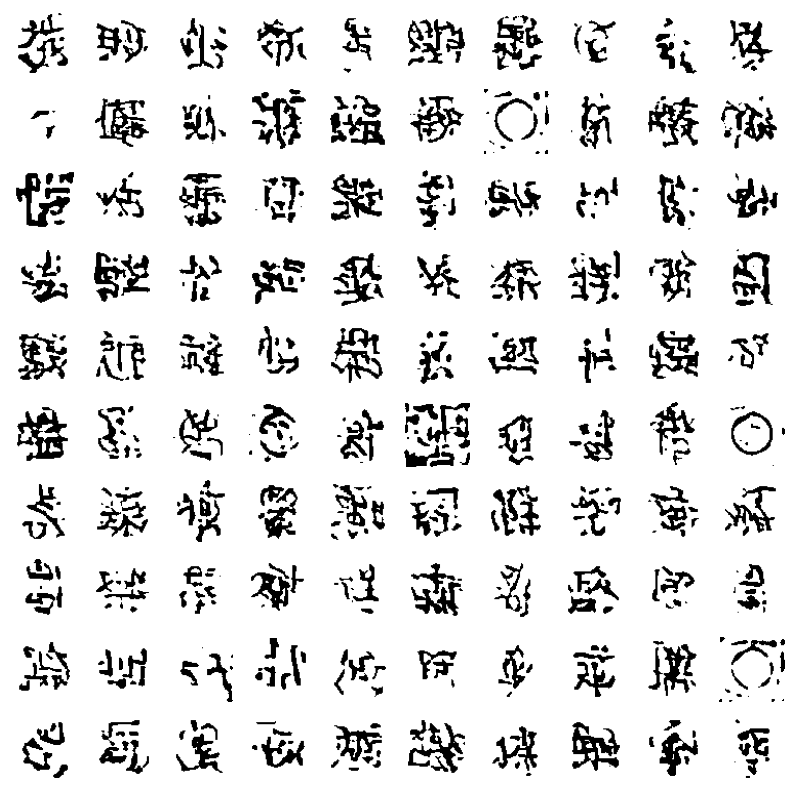

In [9]:
createRandomSet(10,latent_dim,1)

In [57]:
def createInterpolationSet(interpolationSteps,middleSteps):
    
    latentSpaceGlyhs = np.ndarray(shape=((2 + middleSteps) * interpolationSteps , latent_dim), dtype=np.float32)
    
    print("Preparing {} latent space coordinates".format(latentSpaceGlyhs.shape[0]))
    
    StoppingPoints = []
    
    startingGlyph = creatSingleRandom2DVecInSpace(latent_dim,1)

    # We need an odd number of "points" in latent space since we will interpolate between n -> n + 1
    StoppingPoints.append(startingGlyph)

    # Since we want at least one middle point
    for i in range(middleSteps + 1):
        StoppingPoints.append(creatSingleRandom2DVecInSpace(latent_dim,1))

    #Since we want to end up back where we start add the starting glyph again at the end
    StoppingPoints.append(startingGlyph)

    #StoppingPoints should be at least 3 long
    for n in range(len(StoppingPoints) -1):
        latentStep = (StoppingPoints[n+1] - StoppingPoints[n]) / interpolationSteps
        currentStep =  np.copy(StoppingPoints[n])

        for i in range(interpolationSteps):
            currentStep += latentStep
            latentSpaceGlyhs[i + n * interpolationSteps] =  currentStep

    print("Sampling Latent Space for Results")
    predictions = model.sample(latentSpaceGlyhs)
    #fig = plt.figure(figsize=(middleSteps,interpolationSteps ))
    nPredictions = predictions.numpy() * 255
    nPredictions = nPredictions.astype(np.uint8)

    print("Saving Images")
    progressBar = IntProgress(min=0,max=nPredictions.shape[0])
    IPython.display.display(progressBar)
    
    for i in range(nPredictions.shape[0]):
        imgData = nPredictions[i, :, :, 0]
        (imgData-np.min(imgData))/(np.max(imgData)-np.min(imgData)) 
        img = PIL.Image.fromarray(imgData)
        img = postProcessesImage(img)
        img.save("Output/transitionFrame{:04d}.png".format(i))
        progressBar.value += 1

In [58]:
createInterpolationSet(20,10)

Preparing 240 latent space coordinates
Sampling Latent Space for Results
Saving Images


IntProgress(value=0, max=240)